# MCMC Convergence testing

Let us first load the previously created data and env for the task (clearing the area of green and blue squares) with given norms  
<img src="mcmc_convergence/jup_1.jpeg" alt="Drawing" style="width: 520px;float: left"/>                        
<img src="mcmc_convergence/mcmc_data_norms.jpeg" alt="Drawing" style="width: 400px;float: right"/>

In [1]:
from algorithm_1 import algorithm_1,to_tuple
import pickle
from rules_3 import *
from mcmc_convergence import calculate_variance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import sys

In [2]:
with open ('mcmc_convergence/env_convergence.txt', 'rb') as fp:
    env = pickle.load(fp)
print ("Num_objects in env={},\ncolours={},\nshapes={},\nzones={}".format(len(env[0]),env[1],env[2],env[3]))

with open ('mcmc_convergence/data_norms.txt', 'rb') as fp:
    data = pickle.load(fp)
data[:5]

Num_objects in env=30,
colours=['r', 'g', 'b'],
shapes=['square', 'circle', 'triangle'],
zones={1: -0.33333333333333337, 2: 0.33333333333333326, 3: 1.0}


[(('pickup', 13), ('putdown', 13, 3)),
 (('pickup', 13), ('putdown', 13, 3)),
 (('pickup', 13), ('putdown', 13, 3)),
 (('pickup', 13), ('putdown', 13, 3)),
 (('pickup', 13), ('putdown', 13, 3))]

## Create multiple Markov chains

In [3]:
n=10000 #Length of sequence after discarding warm-up part and splitting in half
m=10 #Number of sequences after splitting in half

sequence_list=[]
for i in range(1,int(m/2+1)):
    print ("\n:::::::::::::::::::: FOR SEQUENCE {} ::::::::::::::::::::".format(i))
    exp_seq,lik_list=algorithm_1(data,env,q_dict,rule_dict,
                                           filename="mcmc_convergence/report_for_chain_{}".format(i),max_iterations=4*n,testing=True)
    sequence_list.append(exp_seq)


:::::::::::::::::::: FOR SEQUENCE 1 ::::::::::::::::::::
E0 chosen is:
------------------------------------------------
                NORM Number=1
------------------------------------------------
   > OBLIGATORY to
     PUTDOWN G-SQUAREs in ZONE-2
     if you PICKUP G-SQUAREs
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMITTED to PICKUP
     R-TRIANGLEs in ZONE-1

:::::::::::::::::::: FOR SEQUENCE 2 ::::::::::::::::::::
E0 chosen is:
------------------------------------------------
                NORM Number=1
------------------------------------------------
   > PROHIBITED to PUTDOWN
     R-CIRCLEs in ZONE-1
------------------------------------------------
                NORM Number=2
------------------------------------------------
   > PERMITTED to PUTDOWN
     R-CIRCLEs in ZONE-1

:::::::::::::::::::: FOR SEQUENCE 3 ::::::::::::::::::::
E0 chosen is:
------------------------------------

### Discard the warm-up part for each chain and then split the remaining chain into two halves


In [22]:
def prepare_sequences(sequence_list,warmup=True,split=True): 
    if warmup==True:
        wo_warmup=[sequence[int(len(sequence)/2)+1:] for sequence in sequence_list]
    else:
        wo_warmup=sequence_list
    split_halves=[]
    if split==True:
        for seq in wo_warmup:
            split_halves.append(seq[:int(len(seq)/2)])
            split_halves.append(seq[int(len(seq)/2):])
    else:
        split_halves=wo_warmup
    return (split_halves)

def calculate_R(split_halves,step_size):
    import time
    result={"iterations":[],"R":[],"within_seq_var":[],"between_seq_var":[],"var_over_est":[]}
    counter=0
    flag=0
    n=len(split_halves[0])
    while (counter<n):
        if flag==1:
            counter+=counter
        else:
            counter+=step_size
            flag=1
        counter=min(n,counter)
        s=time.time()
        print ("\nCalculating Variance for 1st {} iterations".format(counter))
        my_seq=[sequence[:counter] for sequence in split_halves]
        W,B=calculate_variance(my_seq)
        result["iterations"].append(counter)
        result["within_seq_var"].append(W)
        result["between_seq_var"].append(B)
        result["var_over_est"].append(((n-1)/n)*W+(1/n)*B)
        result["R"].append((result["var_over_est"][-1]/W)**0.5)
        print ("Time taken for job={:.1f}s".format(time.time()-s))
    result=pd.DataFrame(result)
    return (result)

## Calculate within and between sequence variance
<img src="mcmc_convergence/B_W_def.jpeg" alt="Drawing" style="width: 700px;float: center"/> 

In [26]:
with_warmup_result=calculate_R(prepare_sequences(sequence_list,warmup=True),200)
with_warmup_result


Calculating Variance for 1st 200 iterations
Time taken for job=1.8s

Calculating Variance for 1st 400 iterations
Time taken for job=3.7s

Calculating Variance for 1st 800 iterations
Time taken for job=7.9s

Calculating Variance for 1st 1600 iterations
Time taken for job=16.2s

Calculating Variance for 1st 3200 iterations
Time taken for job=32.3s

Calculating Variance for 1st 6400 iterations
Time taken for job=63.5s

Calculating Variance for 1st 10000 iterations
Time taken for job=100.6s


,iterations,R,within_seq_var,between_seq_var,var_over_est
0,200,1.000402,5.936151,53.682333,5.940925
1,400,1.000518,6.013707,68.325722,6.019938
2,800,1.000374,6.119151,51.944028,6.123734
3,1600,1.000360,6.149259,50.444361,6.153688
4,3200,1.000344,6.164561,48.537597,6.168798
5,6400,1.000345,6.170343,48.731177,6.174599
6,10000,1.000362,6.173420,50.850664,6.177888


In [27]:
wo_warmup_result=calculate_R(prepare_sequences(sequence_list,warmup=False),400)
wo_warmup_result


Calculating Variance for 1st 400 iterations
Time taken for job=4.2s

Calculating Variance for 1st 800 iterations
Time taken for job=8.6s

Calculating Variance for 1st 1600 iterations
Time taken for job=17.9s

Calculating Variance for 1st 3200 iterations
Time taken for job=35.5s

Calculating Variance for 1st 6400 iterations
Time taken for job=71.3s

Calculating Variance for 1st 12800 iterations
Time taken for job=151.8s

Calculating Variance for 1st 20000 iterations
Time taken for job=226.4s


,iterations,R,within_seq_var,between_seq_var,var_over_est
0,400,1.001668,8.002762,542.546833,8.029489
1,800,1.001920,7.518342,585.376667,7.547235
2,1600,1.001074,7.063757,310.621403,7.078935
3,3200,1.000650,6.673813,180.300618,6.682495
4,6400,1.000409,6.439658,111.886406,6.444931
5,12800,1.000335,6.311900,90.900670,6.316130
6,20000,1.000320,6.264438,86.548776,6.268452


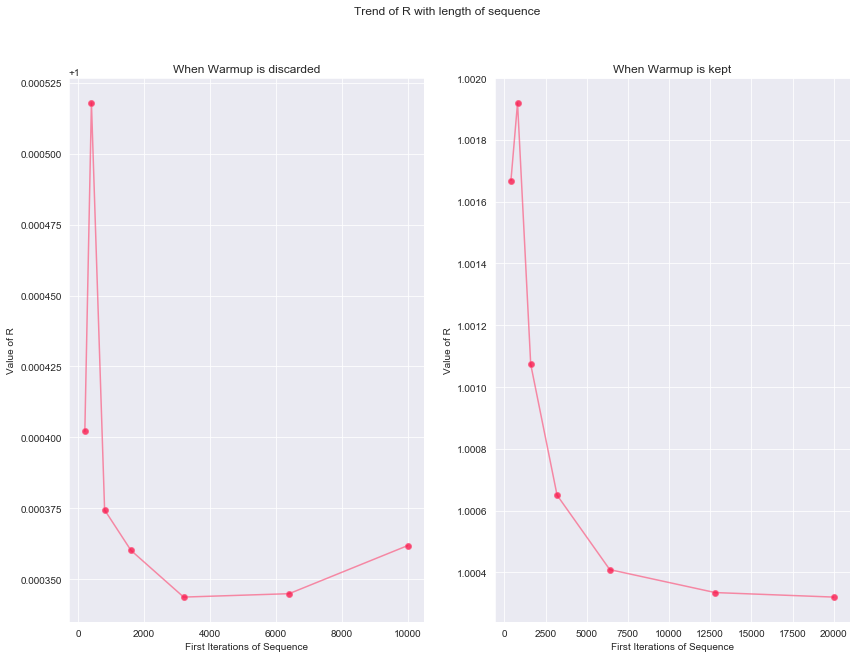

In [28]:
sns.set_style("darkgrid")
fig,ax=plt.subplots(1, 2, sharex=False, sharey=False,figsize=(14,10))
fig.suptitle('Trend of R with length of sequence')

ax[0].plot(with_warmup_result["iterations"].values,with_warmup_result["R"].values,"o-",c=(250/255,93/255,130/255,0.7),markerfacecolor=(250/255,18/255,72/255,0.77))
ax[0].set_ylabel("Value of R")
ax[0].set_xlabel("First Iterations of Sequence")
ax[0].title.set_text("When Warmup is discarded");

ax[1].plot(wo_warmup_result["iterations"].values,wo_warmup_result["R"].values,"o-",c=(250/255,93/255,130/255,0.7),markerfacecolor=(250/255,18/255,72/255,0.77))
ax[1].set_ylabel("Value of R")
ax[1].set_xlabel("First Iterations of Sequence")
ax[1].title.set_text("When Warmup is kept");

### See the learned norms in both the cases and plot their frequencies

In [29]:
learned_norms_with=Counter(map(to_tuple,prepare_sequences(sequence_list,warmup=True)[0]))
t_with=sum(learned_norms_with.values())
print ("For data generated with Warmup:")
print ("Number of unique Norms in sequence={}".format(len(learned_norms_with)))
#print ("Order of Improvement in Likelihood={:.2E}".format(max(lik_list_with)/min(lik_list_with)))

For data generated with Warmup:
Number of unique Norms in sequence=52


In [30]:
learned_norms_wo=Counter(map(to_tuple,prepare_sequences(sequence_list,warmup=False)[0]))
t_wo=sum(learned_norms_wo.values())
print ("For data generated without norms:")
print ("Number of unique Norms in sequence={}".format(len(learned_norms_wo)))
#print ("Order of Improvement in Likelihood={:.2E}".format(max(lik_list_wo)/min(lik_list_wo)))

For data generated without norms:
Number of unique Norms in sequence=147


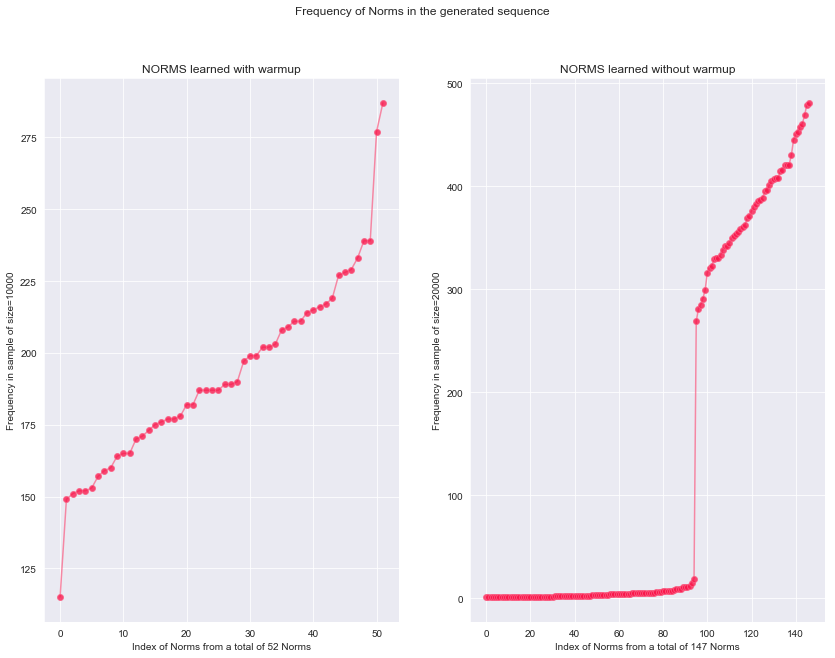

In [31]:
sns.set_style("darkgrid")
fig,ax=plt.subplots(1, 2, sharex=False, sharey=False,figsize=(14,10))
fig.suptitle('Frequency of Norms in the generated sequence')

ax[0].plot(sorted(learned_norms_with.values()),"o-",c=(250/255,93/255,130/255,0.7),markerfacecolor=(250/255,18/255,72/255,0.77))
ax[0].set_ylabel("Frequency in sample of size={}".format(t_with))
ax[0].set_xlabel("Index of Norms from a total of {} Norms".format(len(learned_norms_with)))
ax[0].title.set_text("NORMS learned with warmup")

ax[1].plot(sorted(learned_norms_wo.values()),"o-",c=(250/255,93/255,130/255,0.7),markerfacecolor=(250/255,18/255,72/255,0.77))
ax[1].set_ylabel("Frequency in sample of size={}".format(t_wo))
ax[1].set_xlabel("Index of Norms from a total of {} Norms".format(len(learned_norms_wo)))
ax[1].title.set_text("NORMS learned without warmup")

### Investigate the top_norms learned from a chain with warmup

In [32]:
top=learned_norms_with.most_common()
exists = os.path.isfile('./mcmc_convergence/top_norms_with_warmup.txt')
if exists==True:
    os.remove('./mcmc_convergence/top_norms_with_warmup.txt')
original = sys.stdout
for i in range(len(top)):
    exp=top[i]
    if (i%10==0):
        print("Rank:{} Norm has relative frequency={:.3f}%".format(i+1,exp[1]*100/t_with))
    sys.stdout = open('./mcmc_convergence/top_norms_with_warmup.txt', 'a+')
    print("\n\n\n************Rank:{}, %-Frequency={:.3f}%**********".format(i+1,exp[1]*100/t_with))
    print_expression(exp[0])
    print("*************************************************")
    sys.stdout=original

Rank:1 Norm has relative frequency=2.870%
Rank:11 Norm has relative frequency=2.160%
Rank:21 Norm has relative frequency=1.990%
Rank:31 Norm has relative frequency=1.820%
Rank:41 Norm has relative frequency=1.650%
Rank:51 Norm has relative frequency=1.490%


### Investigate the top_norms learned from a chain without warmup

In [33]:
top=learned_norms_wo.most_common()
exists = os.path.isfile('./mcmc_convergence/top_norms_wo_warmup.txt')
if exists==True:
    os.remove('./mcmc_convergence/top_norms_wo_warmup.txt')
original = sys.stdout
for i in range(len(top)):
    exp=top[i]
    if (i%10==0):
        print("Rank:{} Norm has relative frequency={:.3f}%".format(i+1,exp[1]*100/t_with))
    sys.stdout = open('./mcmc_convergence/top_norms_wo_warmup.txt', 'a+')
    print("\n\n\n************Rank:{}, %-Frequency={:.3f}%**********".format(i+1,exp[1]*100/t_with))
    print_expression(exp[0])
    print("*************************************************")
    sys.stdout=original

Rank:1 Norm has relative frequency=4.810%
Rank:11 Norm has relative frequency=4.210%
Rank:21 Norm has relative frequency=3.950%
Rank:31 Norm has relative frequency=3.600%
Rank:41 Norm has relative frequency=3.330%
Rank:51 Norm has relative frequency=2.810%
Rank:61 Norm has relative frequency=0.090%
Rank:71 Norm has relative frequency=0.050%
Rank:81 Norm has relative frequency=0.050%
Rank:91 Norm has relative frequency=0.040%
Rank:101 Norm has relative frequency=0.020%
Rank:111 Norm has relative frequency=0.020%
Rank:121 Norm has relative frequency=0.010%
Rank:131 Norm has relative frequency=0.010%
Rank:141 Norm has relative frequency=0.010%
